# Select ENSO events Notebook

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
from calendar import month_abbr
import scipy.stats as stats
import math
import pandas as pd

In [2]:
# Import the ERSSTv5 data
ds_obs = xr.open_dataset('/g/data/w97/ah3693-2/CLEX_summer/sst.mnmean.nc')
# Select the Nino3.4 region
sst_nino34 = ds_obs.where((ds_obs.lat<=5) & (ds_obs.lat>=-5) & (ds_obs.lon>=190) & (ds_obs.lon<=240), drop=True)

## NDJ mean method (1)

In [3]:
# Calculate anomaly using base period of 1900-2023
def anom(df):
    gb = df.groupby('time.month')
    gb_base = df.sel(time=slice('1900','2023')).groupby('time.month')
    df_anom = gb - gb_base.mean(dim='time')
    return df_anom
    
sst_nino34_anom = anom(sst_nino34.sst)
index_nino34 = sst_nino34_anom.mean(dim=['lat','lon'])

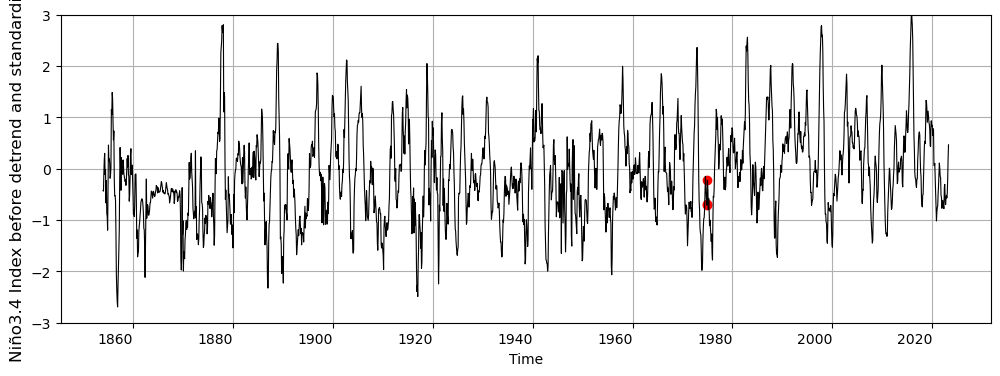

In [4]:
# Plot of before-detrend nino3.4 index
fig, ax = plt.subplots(figsize=(12, 4))
index_nino34.plot(color='black',linewidth=0.8)
index_nino34.sel(time=slice('1974-11-01','1975-01-01')).plot.scatter(color='r',marker='o')

plt.ylabel('Niño3.4 Index before detrend and standardise',fontsize=12)
# plt.xlim((-25600,20000))
plt.xticks(rotation='horizontal')
plt.ylim((-3,3))
ax.grid()
ax.set_axisbelow(True)
plt.show()

# index_nino34.sel(time=slice('1974-11-01','1975-01-01'))

In [5]:
# Find the trend that will be removed for removing the warming
index_nino34_rolling_mean = index_nino34.rolling(time=360,center=True).mean().sel(time=slice('1900','2023'))
trend1 = index_nino34_rolling_mean.copy()
trend2 = index_nino34_rolling_mean.copy()

# climatology reduce 1 month for all months later than 199305
# i from -179 to -90 (inclusive) 
for i in range(-179,0):
    trend1.loc[dict(time=index_nino34['time'].isel(time=i))] = index_nino34.isel(time = slice(i-180,-1)).mean() 

# climatology reduce 2 months for all months later than 199305, always centred at the climatology
for i in range(-179,-89):
    trend2.loc[dict(time=index_nino34['time'].isel(time=i))] = index_nino34.isel(time = slice(i*2,-1)).mean() 
last15_mean = trend2.dropna(dim='time')[-1]
trend2 = trend2.fillna(last15_mean)

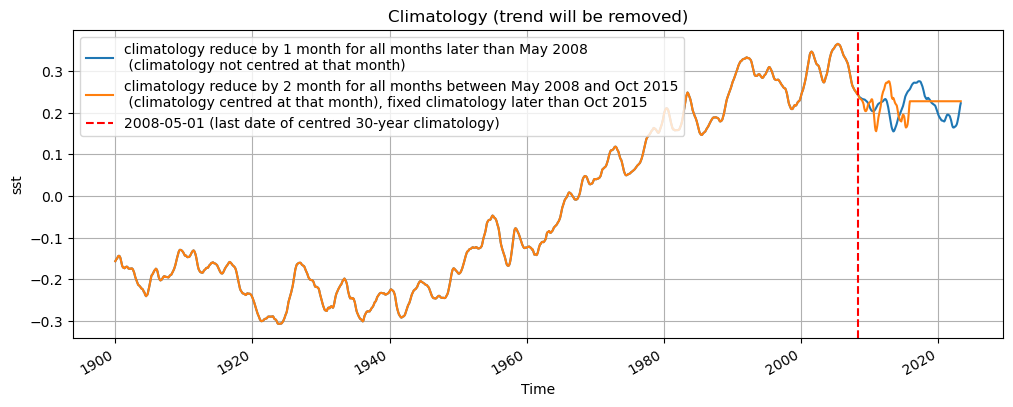

In [6]:
# Plot of climatology
fig, ax = plt.subplots(figsize=(12, 4))
trend1.plot(label='climatology reduce by 1 month for all months later than May 2008\n (climatology not centred at that month)')
trend2.plot(label='climatology reduce by 2 month for all months between May 2008 and Oct 2015\n (climatology centred at that month), fixed climatology later than Oct 2015')
plt.axvline(x=mpl.dates.date2num(pd.to_datetime('2008-05-01')), color='red', linestyle='--', label='2008-05-01 (last date of centred 30-year climatology)')
plt.legend()
plt.title('Climatology (trend will be removed)')
plt.grid()

In [7]:
# Detrend
detrend1 = index_nino34 - trend1
detrend2 = index_nino34 - trend2

std1 = detrend1.std()
std2 = detrend2.std()
print(std1,std2)

<xarray.DataArray 'sst' ()>
array(0.85398442) <xarray.DataArray 'sst' ()>
array(0.85542625)


In [8]:
# Function for finding the years that have NDJ mean reaching the threshold
def find_ENSO_NDJ_mean(detrended_nino34,thr):

    std_nino34 = detrended_nino34.std()

    ndj_mean = detrended_nino34.sel(time=detrended_nino34.time.month.isin([11,12,1])).resample(time = 'AS-Nov').mean(dim='time').isel(time=slice(1, None))

    elnino = ndj_mean.where(ndj_mean>=thr*std_nino34).dropna(dim='time')
    lanina = ndj_mean.where(ndj_mean<=-thr*std_nino34).dropna(dim='time')
    
    elnino_y = elnino.time.dt.year.values
    lanina_y = lanina.time.dt.year.values
    return elnino_y,lanina_y

In [9]:
# elnino_year,lanina_year = find_ENSO(detrended_nino34,0.5)
elnino_year,lanina_year = find_ENSO_NDJ_mean(detrend1,0.6)

print(elnino_year)
print(lanina_year)
print(len(elnino_year),len(lanina_year))

[1902 1904 1905 1911 1913 1914 1918 1919 1921 1923 1925 1930 1940 1941
 1951 1953 1957 1958 1963 1965 1968 1969 1972 1976 1977 1979 1982 1986
 1987 1991 1994 1997 2002 2004 2006 2009 2014 2015 2018 2019]
[1903 1906 1908 1909 1910 1915 1916 1917 1922 1924 1926 1931 1933 1938
 1942 1949 1950 1954 1955 1964 1970 1971 1973 1974 1975 1983 1984 1988
 1995 1998 1999 2000 2005 2007 2008 2010 2011 2016 2017 2020 2021 2022]
40 42


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/lib/python3.9/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)


## NOAA method

In [10]:
# Select the Nino3.4 region
sst_nino34 = ds_obs.where((ds_obs.lat<=5) & (ds_obs.lat>=-5) & (ds_obs.lon>=190) & (ds_obs.lon<=240), drop=True)

In [11]:
weights = np.cos(np.deg2rad(sst_nino34.sst.lat))
weights.name = "weights"

In [12]:
sst_weighted = sst_nino34.sst.weighted(weights)
sst_weighted
weighted_mean = sst_weighted.mean(("lon", "lat"))
weighted_mean

<xarray.DataArray 'sst' (time: 2032)>
array([25.897333, 26.055464, 26.908463, ..., 26.304003, 27.185316,
       27.915052], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1854-01-01 1854-02-01 ... 2023-04-01

In [26]:
# NOAA exactly same method

# function for finding the anomaly of a certain five years using the corresponding 30 year base year period
def anom(df,time_period,base_year):
    gb = df.sel(time=time_period).groupby('time.month')
    gb_base = df.sel(time=base_year).groupby('time.month')
    df_anom = gb - gb_base.mean(dim='time')
    return df_anom

# Calculate anomalies
anomalies = []

# 1900-2010
for year in range(1896,2011,5):
    time_period = slice(str(year),str(year+4))
    base_year = slice(str(year-15),str(year+14))
    
    anomaly = anom(weighted_mean,time_period,base_year)
    anomalies.append(anomaly)

# 2011-2023 (base year fixed to be 1991-2020)
anomaly = anom(weighted_mean, slice(str(2011),str(2023)), slice(str(1991),str(2020)))
anomalies.append(anomaly)

# Concatenate the anomalies along the time dimension
all_anomalies = xr.concat(anomalies, dim='time')

# index = mean sst over the whole region; then, the 3 months rolling mean is calculated
index_nino34 = all_anomalies.rolling(time = 3,center=True).mean().dropna(dim='time').sel(time=slice('1900','2023'))

In [27]:
index_nino34.sel(time=slice('1950','2023')).mean()

<xarray.DataArray 'sst' ()>
array(-0.00162984, dtype=float32)

In [28]:
index_nino34 = index_nino34.round(1)

In [30]:
# Print the table of the indices I calculated

# Get the years and months from the index_nino34 DataArray
year_index = np.arange(1900,2024,1)
years = index_nino34['time.year'].values
months = index_nino34['time.month'].values

# Create an empty DataFrame to store the table
index_nino34_df = pd.DataFrame(index=year_index, columns=month_abbr[1:])

# Iterate over the data and populate the DataFrame
for year, month, value in zip(years, months, index_nino34.values):
    index_nino34_df.at[year, month_abbr[month]] = value

formatted_table = index_nino34_df.applymap('{:.1f}'.format)
    
# Print the entire table
print(formatted_table.to_string(index=True))

       Jan   Feb   Mar   Apr   May   Jun   Jul   Aug   Sep   Oct   Nov   Dec
1900   1.6   1.5   1.4   1.2   1.1   1.1   0.8   0.7   0.5   0.5   0.5   0.4
1901   0.5   0.5   0.3   0.1  -0.1  -0.3  -0.3  -0.3  -0.3  -0.2  -0.2  -0.1
1902  -0.0   0.2   0.5   0.7   0.9   1.2   1.6   1.9   2.1   2.3   2.1   1.9
1903   1.6   1.4   0.9   0.4   0.1  -0.2  -0.6  -0.9  -1.1  -1.1  -1.1  -1.3
1904  -1.4  -1.5  -1.1  -0.7  -0.3  -0.1   0.1   0.2   0.3   0.5   0.7   0.9
1905   1.0   1.1   1.1   1.2   1.2   1.3   1.5   1.6   1.6   1.5   1.2   1.1
1906   0.9   0.7   0.4   0.2  -0.2  -0.4  -0.6  -0.6  -0.5  -0.4  -0.5  -0.7
1907  -0.9  -0.8  -0.6  -0.4  -0.2  -0.1   0.1   0.2   0.3   0.1  -0.0  -0.1
1908  -0.0   0.0  -0.2  -0.5  -0.6  -0.5  -0.4  -0.5  -0.6  -0.8  -1.0  -1.2
1909  -1.3  -1.1  -0.8  -0.6  -0.6  -0.7  -0.7  -0.9  -1.1  -1.3  -1.3  -1.4
1910  -1.5  -1.6  -1.4  -1.2  -0.9  -0.9  -0.9  -1.0  -1.0  -1.0  -1.0  -1.0
1911  -1.0  -0.9  -0.7  -0.6  -0.3   0.1   0.4   0.5   0.7   0.9   1.2   1.3

### NOAA method **with** the precondition of 5 consecutive ENSO events (2)

In [32]:
# Set the threshold value
threshold = 0.5

# Create a mask for values greater than the threshold
mask_EN = (index_nino34 >= threshold)  #El Nino
mask_LN = (index_nino34 <= -threshold) #La Nina

# Find the consecutive months with the threshold condition; this only contains the last month of a five-month consecutive event
consecutive_months_EN = mask_EN.rolling(time=5).sum() >= 5
consecutive_months_LN = mask_LN.rolling(time=5).sum() >= 5

# Select the months that meet both the threshold and consecutive months condition
selected_index_EN = index_nino34.where(consecutive_months_EN).dropna(dim='time')
selected_index_LN = index_nino34.where(consecutive_months_LN).dropna(dim='time')

elnino_y = selected_index_EN.sel(time = selected_index_EN.time.dt.month.isin([12])) # Event ending at NDJ
elnino_y2 = selected_index_EN.sel(time = selected_index_EN.time.dt.month.isin([1,2,3,4])) # Event ending at DJF, JFM, FMA, MAM
lanina_y = selected_index_LN.sel(time = selected_index_LN.time.dt.month.isin([12])) # same for La Nina
lanina_y2 = selected_index_LN.sel(time = selected_index_LN.time.dt.month.isin([1,2,3,4]))

# Format the list to be an ascending array of all years without duplication
elnino_year = np.sort(list(set(np.append(elnino_y.time.dt.year.values,elnino_y2.time.dt.year.values-1)))) 
lanina_year = np.sort(list(set(np.append(lanina_y.time.dt.year.values,lanina_y2.time.dt.year.values-1))))

print(elnino_year)
print(lanina_year)
print(len(elnino_year),len(lanina_year))

[1902 1904 1905 1911 1913 1914 1918 1919 1923 1925 1930 1939 1940 1941
 1951 1953 1957 1958 1963 1965 1968 1969 1972 1976 1977 1979 1982 1986
 1987 1991 1994 1997 2002 2004 2006 2009 2014 2015 2018]
[1903 1906 1908 1909 1910 1915 1916 1917 1922 1924 1933 1938 1942 1949
 1954 1955 1964 1970 1971 1973 1974 1975 1983 1984 1988 1995 1998 1999
 2000 2005 2007 2008 2010 2011 2016 2017 2020 2021 2022]
39 39


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/lib/python3.9/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)


In [18]:
mask_EN

<xarray.DataArray 'sst' (time: 1479)>
array([ True,  True,  True, ..., False, False, False])
Coordinates:
  * time     (time) datetime64[ns] 1900-01-01 1900-02-01 ... 2023-03-01
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 5 6 7 8 9 10 11 12 1 2 3

(1950.0, 2020.0)

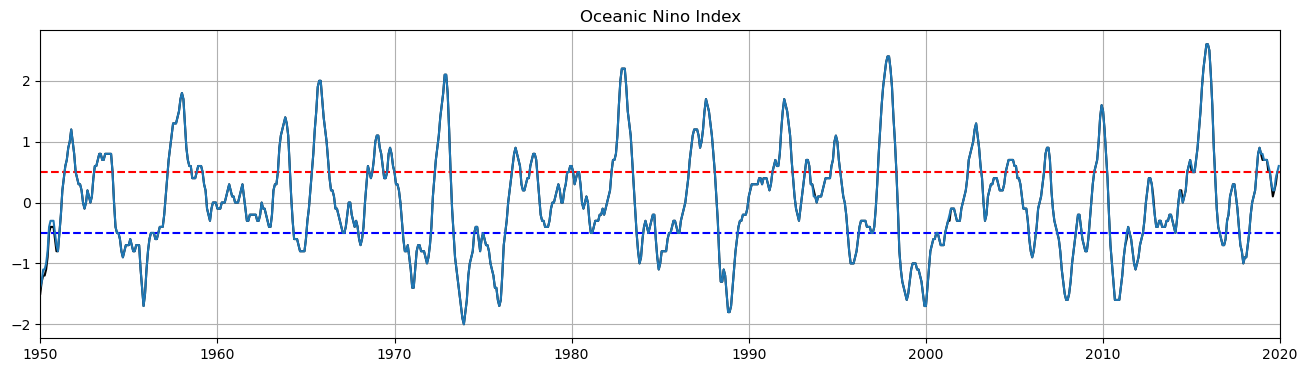

In [19]:
ONI_data = np.loadtxt('/g/data/w97/zg0866/ForAshley/ONI_NOAA_1950_2022.txt', skiprows=1)
ONI = ONI_data[:70,:] #first column is years
ONI_all = np.reshape(ONI[:,1:],(840,))
month_oni = np.linspace(1950,2019+11/12,840)

plt.figure(figsize=[16,4])
plt.plot(month_oni,ONI_all,'k-')
plt.plot([1950,2020],[0.5,0.5],'r--')
plt.plot([1950,2020],[-0.5,-0.5],'b--')

plt.plot(month_oni,index_nino34.sel(time=slice('1950','2019')).values)

plt.title('Oceanic Nino Index')
plt.grid()
plt.xlim(1950,2020)

### NOAA method **without** the precondition of 5 consecutive ENSO events (3)

In [20]:
index_nino34_ndj = index_nino34.sel(time = index_nino34.time.dt.month.isin([12]))

thr = 0.5

elnino = index_nino34_ndj.where(index_nino34_ndj>=thr).dropna(dim='time')
lanina = index_nino34_ndj.where(index_nino34_ndj<=-thr).dropna(dim='time')

elnino_year = elnino.time.dt.year.values
lanina_year = lanina.time.dt.year.values

print(elnino_year)
print(lanina_year)
print(len(elnino_year),len(lanina_year))

[1902 1904 1905 1911 1913 1914 1918 1919 1921 1923 1925 1930 1939 1940
 1941 1951 1953 1957 1958 1963 1965 1968 1969 1972 1976 1977 1979 1982
 1986 1987 1991 1994 1997 2002 2004 2006 2009 2014 2015 2018 2019]
[1903 1906 1908 1909 1910 1912 1915 1916 1917 1922 1924 1926 1931 1933
 1938 1942 1949 1950 1954 1955 1964 1970 1971 1973 1974 1975 1983 1984
 1988 1995 1996 1998 1999 2000 2005 2007 2008 2010 2011 2016 2017 2020
 2021 2022]
41 44
